In [5]:
import sys
import os

__dir__ = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(__dir__)
sys.path.insert(0, os.path.abspath(os.path.join(__dir__, "..")))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


In [6]:
import numpy as np
from skimage.transform import resize
# import craft functions
from my_craft_text_detector.craft_text_detector import (
    read_image,
    load_craftnet_model,
    load_refinenet_model,
    get_prediction,
    export_detected_regions,
    export_extra_results,
    empty_cuda_cache
)
import os
# os.listdir("/data/ocr/data/text_recognition/ocr_data_v3_280225/Arial_Bold/images/img_18563.jpg")
import matplotlib.pyplot as plt
import cv2

In [7]:
refine_net = load_refinenet_model(cuda=True)
craft_net = load_craftnet_model(cuda=True)

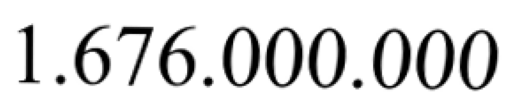

In [8]:
image_path = "/home/app/ocr/vts-document-ai/text_extractor/output/img_]CÓ]ÓCOOOCOOO_1.png"
# image_path = "/home/app/ocr/vts-document-ai/text_extractor/output/img_1ưmg_3.png"
# image_path = "/home/app/ocr/vts-document-ai/text_extractor/output/img_NƠ_1.png"
image = cv2.imread(image_path)
h,w,_ = image.shape
plt.axis('off')
plt.imshow(image)

In [9]:
desired_long_size = max(h,w)
ratio = desired_long_size/max(h,w)
unpadded_target_h = int(h * ratio)
unpadded_target_w = int(w*ratio)
padded_h = 32 if not unpadded_target_h%32 else unpadded_target_h%32
padded_w = 32 if not unpadded_target_w%32 else unpadded_target_w%32
padded_target_h = unpadded_target_h + 32 - padded_h
padded_target_w = unpadded_target_w + 32 - padded_w

print(padded_target_h)
print(padded_target_w)

64
288


In [10]:
# set image path and export folder directory
output_dir = 'outputs/'

# read image
# image = read_image(image)
# perform prediction
prediction_result = get_prediction(
    image=image,
    craft_net=craft_net,
    # refine_net=refine_net,
    text_threshold=0.6,
    link_threshold=1,
    low_text=0.6,
    cuda=True,
    long_size=desired_long_size
)

# export detected text regions
exported_file_paths = export_detected_regions(
    image=image,
    regions=prediction_result["boxes"],
    output_dir=output_dir,
    rectify=True
)

# export heatmap, detection points, box visualization
export_extra_results(
    image=image,
    regions=prediction_result["boxes"],
    heatmaps=prediction_result["heatmaps"],
    output_dir=output_dir
)

# unload models from gpu
empty_cuda_cache()

In [11]:
text_score = prediction_result['score_text']
link_score = prediction_result['score_link']
# resized_arr = resize(array_img, (h,w), anti_aliasing=True)
resized_textscore = resize(text_score, (padded_target_h, padded_target_w), anti_aliasing=True)
resized_linkscore = resize(link_score, (padded_target_h, padded_target_w), anti_aliasing=True)

resized_textscore = resized_textscore[:unpadded_target_h, :unpadded_target_w]
resized_linkscore = resized_linkscore[:unpadded_target_h, :unpadded_target_w]

resized_textscore = resize(resized_textscore, (h,w), cv2.INTER_LINEAR)
resized_linkscore = resize(resized_linkscore, (h,w), cv2.INTER_LINEAR)


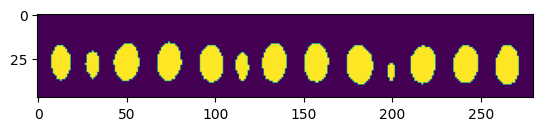

In [12]:
ret,link_mask = cv2.threshold(resized_linkscore, 0.5,1,0)
ret, score_mask = cv2.threshold(resized_textscore, 0.6,1,0)
plt.imshow(score_mask)

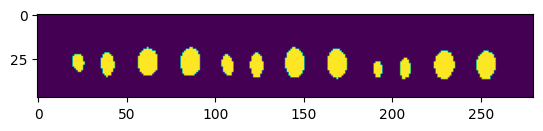

In [13]:
plt.imshow(link_mask)

Number of connected components in score_mask: 14
Number of connected components in link_mask: 13


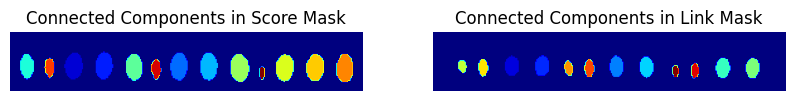

In [14]:
# Get connected components for score_mask
num_labels_score, labels_im_score = cv2.connectedComponents(score_mask.astype(np.uint8))

# Get connected components for link_mask
num_labels_link, labels_im_link = cv2.connectedComponents(link_mask.astype(np.uint8))

print(f"Number of connected components in score_mask: {num_labels_score}")
print(f"Number of connected components in link_mask: {num_labels_link}")

# Display the labels
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Connected Components in Score Mask")
plt.imshow(labels_im_score, cmap='jet')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Connected Components in Link Mask")
plt.imshow(labels_im_link, cmap='jet')
plt.axis('off')

plt.show()

In [15]:
# Create a list of (leftmost, rightmost) for each connected component in score_mask
score_boundaries = []
for label in range(1, num_labels_score):  # skipping background label 0
    rows, cols = np.where(labels_im_score == label)
    if cols.size:
        leftmost = int(np.min(cols))
        rightmost = int(np.max(cols))
        score_boundaries.append((leftmost, rightmost))

# Create a list of (leftmost, rightmost) for each connected component in link_mask
link_boundaries = []
for label in range(1, num_labels_link):  # skipping background label 0
    rows, cols = np.where(labels_im_link == label)
    if cols.size:
        leftmost = int(np.min(cols))
        rightmost = int(np.max(cols))
        link_boundaries.append((leftmost, rightmost))

print("Score Mask Boundaries (leftmost, rightmost):", score_boundaries)
print("Link Mask Boundaries (leftmost, rightmost):", link_boundaries)

Score Mask Boundaries (leftmost, rightmost): [(43, 57), (68, 81), (127, 140), (151, 164), (8, 18), (92, 104), (175, 189), (211, 224), (235, 248), (259, 271), (27, 34), (112, 119), (198, 201)]
Link Mask Boundaries (leftmost, rightmost): [(57, 67), (81, 91), (140, 150), (164, 174), (224, 235), (248, 258), (20, 26), (36, 43), (104, 110), (120, 127), (205, 210), (190, 194)]


(47, 280, 3)
(47, 280)


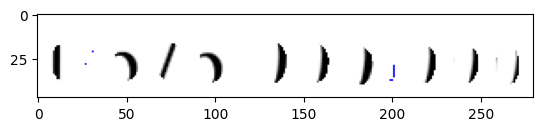

In [20]:
print(image.shape)
print(score_mask.shape)
mask = np.stack([score_mask, score_mask, score_mask], axis=-1)
mask = mask.astype(np.uint8)

plt.imshow(mask*image + (1-mask)*255)

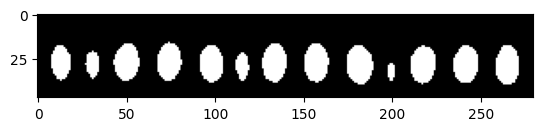

In [21]:
plt.imshow(mask*255)


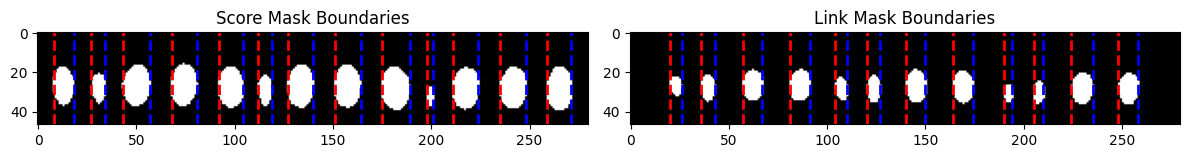

In [22]:
# Visualize the leftmost and rightmost boundaries for score_mask and link_mask

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot score_mask with boundaries
axes[0].imshow(score_mask, cmap='gray')
axes[0].set_title('Score Mask Boundaries')
for left, right in score_boundaries:
    axes[0].axvline(left, color='red', linestyle='--', linewidth=2)
    axes[0].axvline(right, color='blue', linestyle='--', linewidth=2)

# Plot link_mask with boundaries
axes[1].imshow(link_mask, cmap='gray')
axes[1].set_title('Link Mask Boundaries')
for left, right in link_boundaries:
    axes[1].axvline(left, color='red', linestyle='--', linewidth=2)
    axes[1].axvline(right, color='blue', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

In [23]:
# For each score mask boundary, find:
# - the nearest link component whose leftmost coordinate is greater than score_left
# - the nearest link component whose rightmost coordinate is less than score_right

nearest_matches = []

for s_left, s_right in score_boundaries:
    # Find candidates in link_boundaries with leftmost coordinate bigger than score component's left
    right_candidates = [lb for lb in link_boundaries if lb[0] > s_left]
    nearest_right = min(right_candidates, key=lambda lb: lb[0] - s_left) if right_candidates else None
    
    # Find candidates in link_boundaries with rightmost coordinate smaller than score component's right
    left_candidates = [lb for lb in link_boundaries if lb[1] < s_right]
    nearest_left = max(left_candidates, key=lambda lb: lb[1]) if left_candidates else None
    
    nearest_matches.append(((s_left, s_right), nearest_right, nearest_left))
    print(f"Score component {(s_left, s_right)}: nearest right component: {nearest_right}, nearest left component: {nearest_left}")

Score component (43, 57): nearest right component: (57, 67), nearest left component: (36, 43)
Score component (68, 81): nearest right component: (81, 91), nearest left component: (57, 67)
Score component (127, 140): nearest right component: (140, 150), nearest left component: (120, 127)
Score component (151, 164): nearest right component: (164, 174), nearest left component: (140, 150)
Score component (8, 18): nearest right component: (20, 26), nearest left component: None
Score component (92, 104): nearest right component: (104, 110), nearest left component: (81, 91)
Score component (175, 189): nearest right component: (190, 194), nearest left component: (164, 174)
Score component (211, 224): nearest right component: (224, 235), nearest left component: (205, 210)
Score component (235, 248): nearest right component: (248, 258), nearest left component: (224, 235)
Score component (259, 271): nearest right component: None, nearest left component: (248, 258)
Score component (27, 34): neares

In [24]:
# For each match in nearest_matches, extract the left coordinate from the nearest left
# component and the right coordinate from the nearest right component, skipping any tuple
# where one of these is None.

extracted_coordinates = []
for score_bounds, nearest_right, nearest_left in nearest_matches:
    # if nearest_right is None or nearest_left is None:
    #     continue
    # print(score_bounds, nearest_right, nearest_left)
    if nearest_right is None:
        # right_coord = score_bounds[1]
        right_coord = w
    else:
        right_coord = nearest_right[1]
    if nearest_left is None:
        # left_coord = score_bounds[0]
        left_coord = 0
    else:
        left_coord = nearest_left[0]
    extracted_coordinates.append((left_coord, right_coord))
    # print(extracted_coordinates)

print(extracted_coordinates)

[(36, 67), (57, 91), (120, 150), (140, 174), (0, 26), (81, 110), (164, 194), (205, 235), (224, 258), (248, 280), (20, 43), (104, 127), (190, 210)]


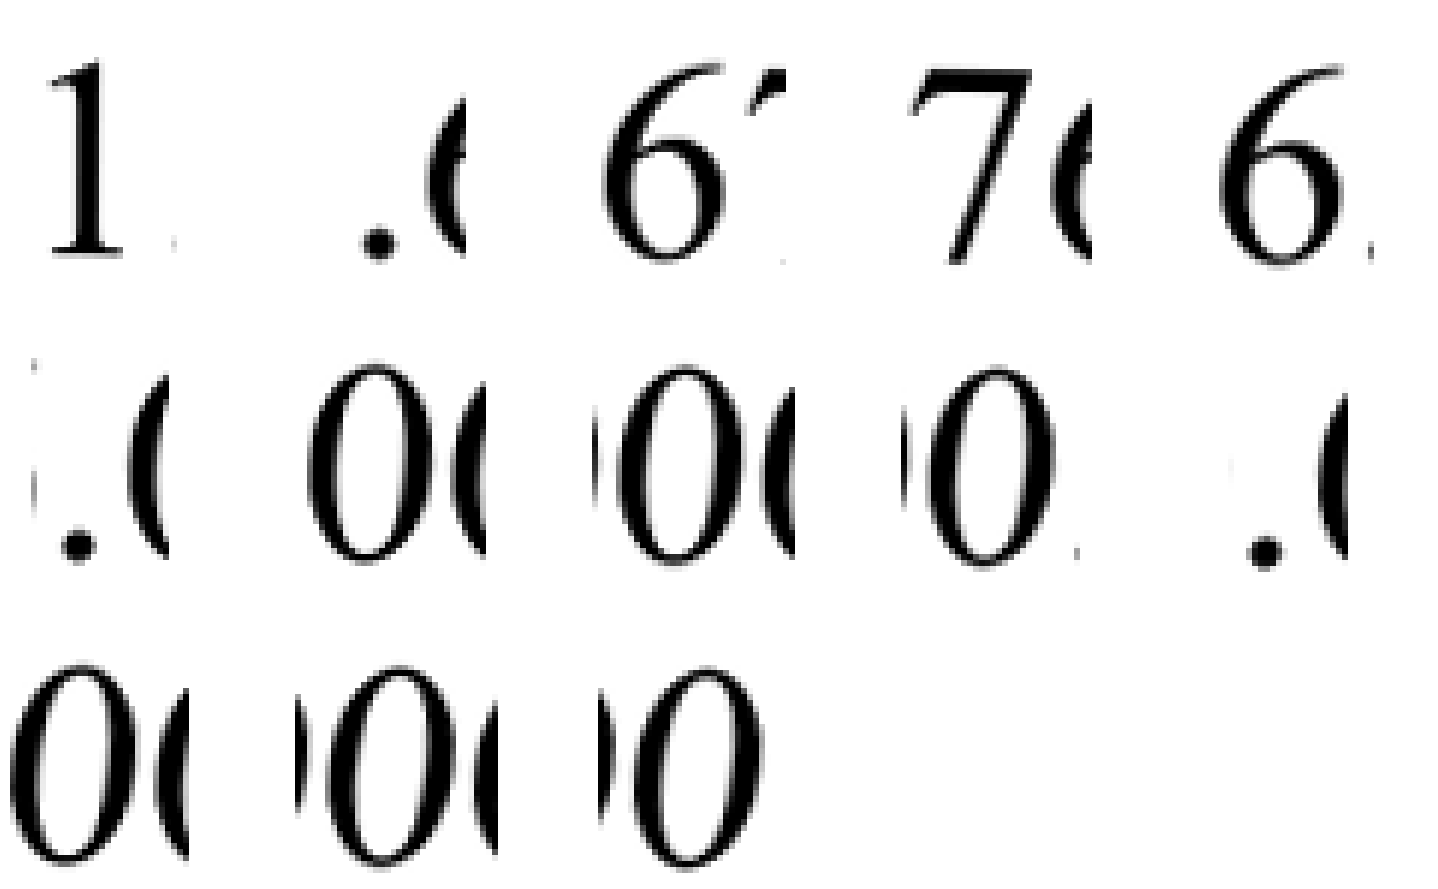

In [25]:
image = cv2.imread(image_path)
# Sort the extracted_coordinates based on the x_start value
sorted_extracted_coordinates = sorted(extracted_coordinates, key=lambda x: x[0])

# Crop each box from the image using the sorted extracted_coordinates.
sorted_crops = [image[:, x_start:x_end] for (x_start, x_end) in sorted_extracted_coordinates]

# Set up the plotting grid: 5 images per row.
n_images = len(sorted_crops)
n_cols = 5
n_rows = math.ceil(n_images / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()  # flatten the grid for easy iteration

for ax, crop in zip(axes, sorted_crops):
    # Convert BGR to RGB for displaying correctly.
    crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    ax.imshow(crop_rgb)
    ax.axis("off")

# Hide any extra subplots
for ax in axes[len(sorted_crops):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [28]:
# # Sort the score_boundaries based on the x_start value
# sorted_score_boundaries = sorted(score_boundaries, key=lambda x: x[0])

# # Crop each box from the image using the sorted score_boundaries.
# sorted_crops = [image[:, x_start:x_end] for (x_start, x_end) in sorted_score_boundaries]

# # Set up the plotting grid: 5 images per row.
# n_images = len(sorted_crops)
# n_cols = 5
# n_rows = math.ceil(n_images / n_cols)

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
# axes = axes.flatten()  # flatten the grid for easy iteration

# for ax, crop in zip(axes, sorted_crops):
#     # Convert BGR to RGB for displaying correctly.
#     crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
#     ax.imshow(crop_rgb)
#     ax.axis("off")

# # Hide any extra subplots
# for ax in axes[len(sorted_crops):]:
#     ax.axis("off")

# plt.tight_layout()
# plt.show()

In [1]:
from SplittingCraft import *
import cv2
import math

/opt/miniconda3/envs/ocr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
splitter = SplittingCraft()

In [ ]:
#Command
image_path = "/home/app/ocr/vts-document-ai/text_extractor/output/img_h]ệm_7.png"

image = cv2.imread(image_path)

In [25]:
crops = splitter(image)

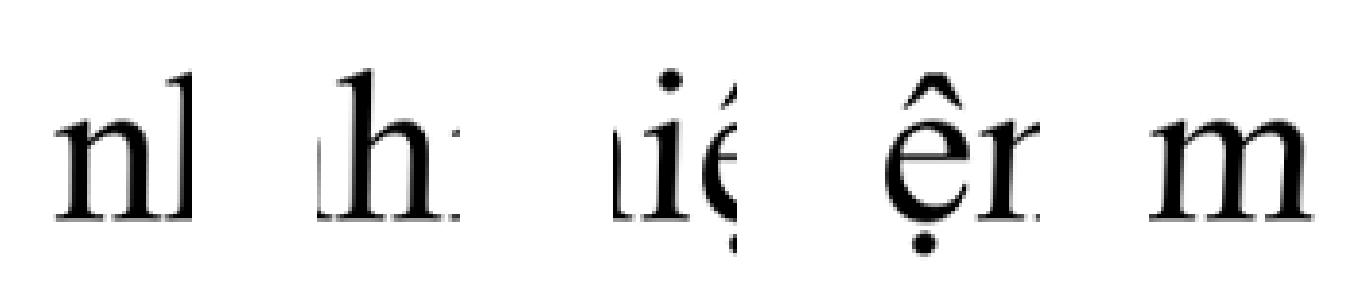

In [26]:
n_images = len(crops)
n_cols = 5
n_rows = math.ceil(n_images / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()  # flatten the grid for easy iteration

for ax, crop in zip(axes, crops):
    # Convert BGR to RGB for displaying correctly.
    crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    ax.imshow(crop_rgb)
    ax.axis("off")

# Hide any extra subplots
for ax in axes[len(crops):]:
    ax.axis("off")

plt.tight_layout()
plt.show()